# Projeto de Filtro FIR Passa-Baixa com Janela de Kaiser

## Introdução

Filtros FIR (Finite Impulse Response) apesar de apresentar uma ordem elevada, são amplamente utilizados devido à sua estabilidade, precisão e fase linear. Neste trabalho, projetamos um filtro FIR passa-baixa usando o método da janela de Kaiser, garantindo:

- Atenuação na banda rejeitada ≥ 50 dB
- Frequência de corte: ωc = π/2
- Região de transição: Δω < 0,1π

<img src="./images/FiltroGeral.png">

Para isso, empregamos a biblioteca SciPy para calcular a resposta do filtro e suas transformações.

## Filtro FIR Passa-Baixa

O filtro será projetado pelo método da janela, usando a janela de Kaiser, que permite controlar a transição e atenuação com o parâmetro β.

### Cálculo do Parâmetro β

O valor de β depende da atenuação desejada:

<img src="./images/CalculoBeta.png" />

In [3]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Parâmetros do filtro
atenuacao_desejada = 50  # dB
frequencia_corte = np.pi / 2  # ωc = π/2
largura_transicao = 0.1 * np.pi  # Δω < 0,1π

# Cálculo do parâmetro β
beta = 0.5842 * (atenuacao_desejada - 21) ** 0.4 + 0.07886 * (atenuacao_desejada - 21) 

print(f"Parâmetro β calculado: {beta}")

Parâmetro β calculado: 4.533514120981248


### Projeto do Filtro

Com o valor de β calculado, podemos projetar o filtro FIR passa-baixa usando a janela de Kaiser. A seguir, apresentamos o código para projetar o filtro e plotar sua resposta em frequência.

O valor de M será:

<img src="./images/CalculoM.png" />

In [4]:
# Cálculo da ordem M do filtro (num_taps)
M = int(np.ceil((atenuacao_desejada - 8) / (2.285 * largura_transicao)))
print(f"Parâmetro M calculado: {M}")

Parâmetro M calculado: 59


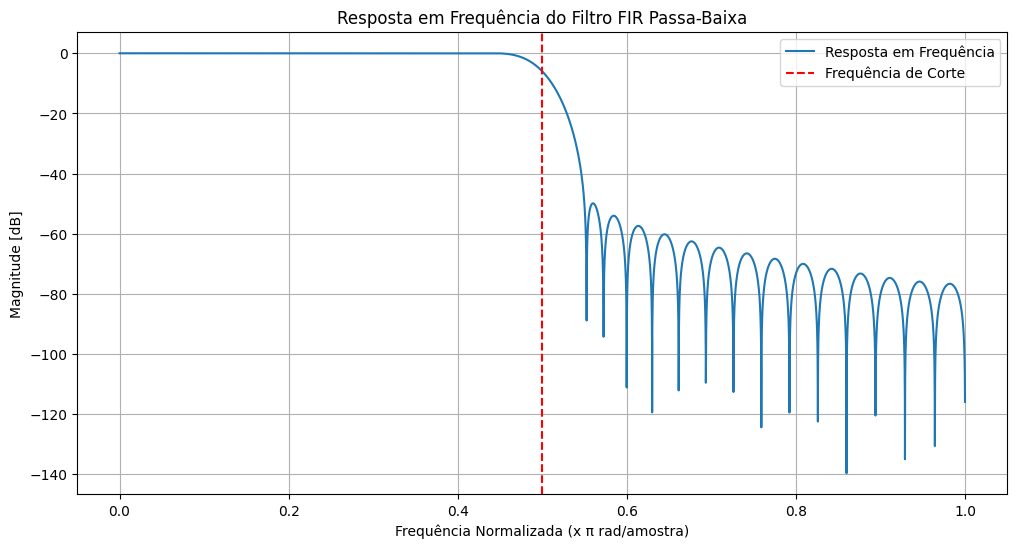

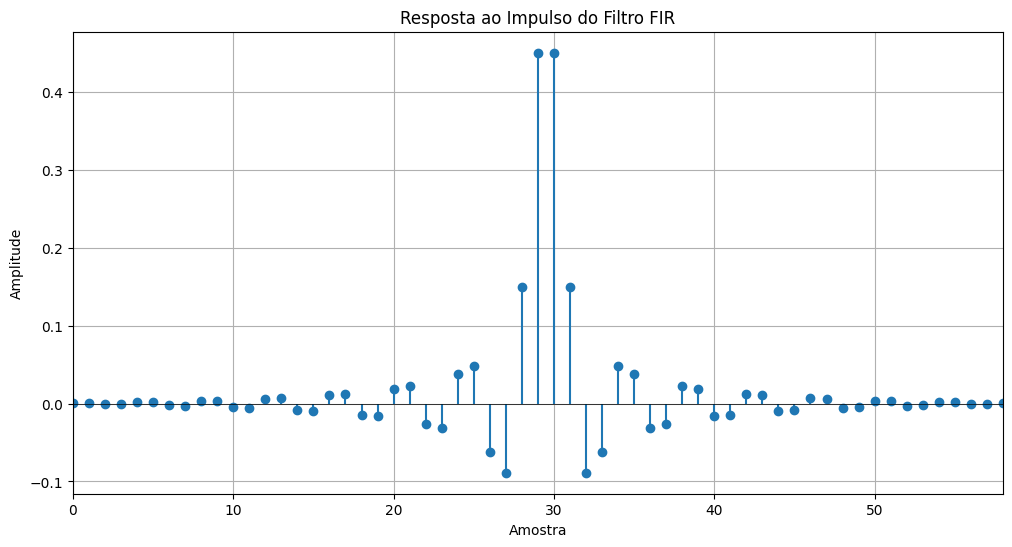

In [50]:
# Projeta o filtro FIR
h_fir = signal.firwin(M + 1, frequencia_corte / np.pi, window=('kaiser', beta), scale=False)

# Resposta em frequência do filtro
frequencias, resposta = signal.freqz(h_fir, worN=8000)

# Plot da resposta em frequência
plt.figure(figsize=(12, 6))
plt.plot(frequencias / np.pi, 20 * np.log10(np.abs(resposta)), label='Resposta em Frequência')

# Configuração do gráfico
plt.title('Resposta em Frequência do Filtro FIR Passa-Baixa')
plt.xlabel('Frequência Normalizada (x π rad/amostra)')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.axvline(frequencia_corte / np.pi, color='red', linestyle='--', label='Frequência de Corte')
plt.legend()
plt.show()

# Plotando resposta ao impulso do filtro
plt.figure(figsize=(12, 6))
plt.stem(range(M+1), h_fir[:M+1], basefmt=" ")
plt.title('Resposta ao Impulso do Filtro FIR')
plt.xlabel('Amostra')
plt.ylabel('Amplitude')
plt.xlim(0, M - 1)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)  # Linha central
plt.grid(True)  # Ativar grade para melhor visualização
plt.show()

Como esperado, o filtro oscilante na faixa de rejeição e a frequencia de corte em π/2 e a nossa resposta ao impulso com moldes de uma sinc. Podemos também obter o diagrama de polos e zeros do nosso filtro:

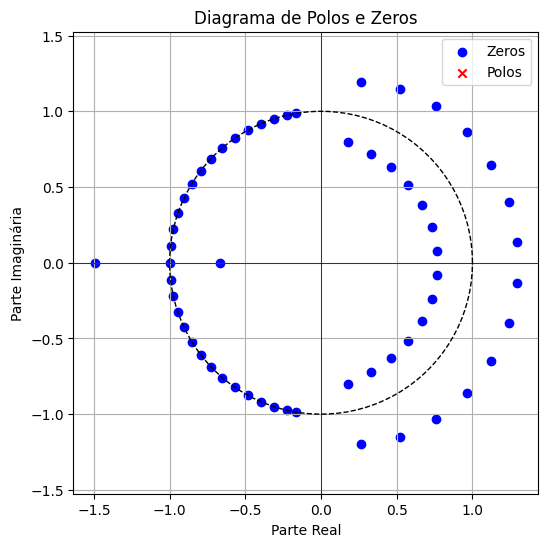

In [55]:
z, p, k = signal.tf2zpk(h_fir, [1])

# Criar o diagrama de polos e zeros
plt.figure(figsize=(6, 6))
plt.scatter(np.real(z), np.imag(z), marker='o', color='blue', label='Zeros')
plt.scatter(np.real(p), np.imag(p), marker='x', color='red', label='Polos')

# Desenhar o círculo unitário
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='dashed', color='black', linewidth=1)

# Configuração do gráfico
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.title('Diagrama de Polos e Zeros')
plt.grid(True)
plt.legend()
plt.axis('equal')  # Para manter a proporção circular
plt.show()

Por se tratar de um filtro FIR, apenas temos zeros ( o denominador é 1). Observa-se que estamos diantes de um filtro FIR do tipo II, em que o α não é uma amostra. É possível inferir, também, de que se trata de um filtro passa-baixas, devido a anulação das altas frequências e permição da passagem de baixas frequências.

### Implementação nas Formas Direta e em Cascata

A *forma direta* utiliza os coeficientes do filtro diretamente. A *forma em cascata* decompõe o filtro em seções de segunda ordem (SOS). Vamos usar a função tf2sos da SciPy para converter a forma direta em cascata. Vamos quantizar os coeficientes para estudar a sensibilidade à quantização.



In [56]:
from scipy.signal import tf2sos

# Forma direta
print("Coeficientes da forma direta (precisão infinita):")
print(h_fir )

# Forma em cascata
sos = tf2sos(h_fir , 1)  # Converte para seções de segunda ordem (SOS)
print("\nCoeficientes da forma em cascata (precisão infinita):")
print(sos)



Coeficientes da forma direta (precisão infinita):
[ 4.23762209e-04  6.02198652e-04 -8.16057159e-04 -1.06930606e-03
  1.36620371e-03  1.71134743e-03 -2.10974070e-03 -2.56688439e-03
  3.08890004e-03  3.68269628e-03 -4.35619355e-03 -5.11862922e-03
  5.98097465e-03  6.95651129e-03 -8.06163671e-03 -9.31701094e-03
  1.07492180e-02  1.23932302e-02 -1.42961620e-02 -1.65231714e-02
  1.91670887e-02  2.23648412e-02 -2.63270122e-02 -3.13946767e-02
  3.81582270e-02  4.77346115e-02 -6.25198094e-02 -8.87471950e-02
  1.49279269e-01  4.49899875e-01  4.49899875e-01  1.49279269e-01
 -8.87471950e-02 -6.25198094e-02  4.77346115e-02  3.81582270e-02
 -3.13946767e-02 -2.63270122e-02  2.23648412e-02  1.91670887e-02
 -1.65231714e-02 -1.42961620e-02  1.23932302e-02  1.07492180e-02
 -9.31701094e-03 -8.06163671e-03  6.95651129e-03  5.98097465e-03
 -5.11862922e-03 -4.35619355e-03  3.68269628e-03  3.08890004e-03
 -2.56688439e-03 -2.10974070e-03  1.71134743e-03  1.36620371e-03
 -1.06930606e-03 -8.16057159e-04  6.0219

### Análise da Sensibilidade à Quantização
Vamos comparar a resposta em frequência do filtro com precisão infinita e com precisão finita

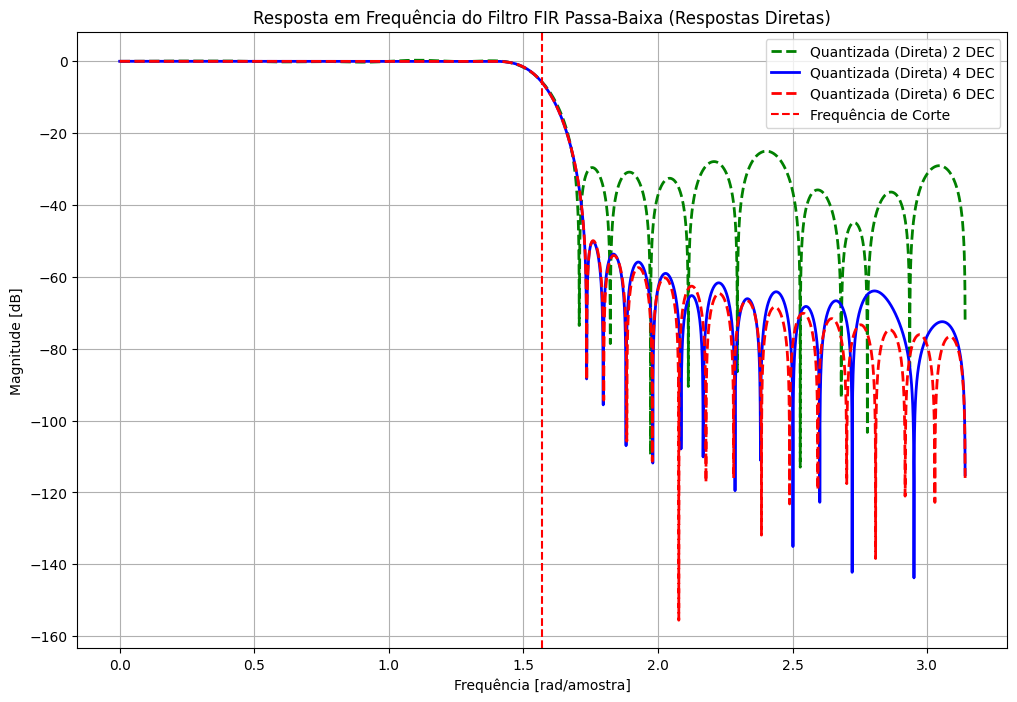

In [70]:
# Quantização dos coeficientes (exemplo: 2 casas decimais)
h_fir_quantizados_2dec = np.round(h_fir, decimals=2)
sos_quantizados_2dec = np.round(sos, decimals=2)

# Quantização dos coeficientes (exemplo: 4 casas decimais)
h_fir_quantizados_4dec = np.round(h_fir, decimals=4)
sos_quantizados_4dec = np.round(sos, decimals=4)

# Quantização dos coeficientes (exemplo: 6 casas decimais)
h_fir_quantizados_6dec = np.round(h_fir, decimals=6)
sos_quantizados_6dec = np.round(sos, decimals=6)



# Resposta em frequência para a forma direta quantizada
frequencias_q_2dec, resposta_direta_quantizada_2dec = signal.freqz(h_fir_quantizados_2dec, worN=8000)
frequencias_q_4dec, resposta_direta_quantizada_4dec = signal.freqz(h_fir_quantizados_4dec, worN=8000)
frequencias_q_6dec, resposta_direta_quantizada_6dec = signal.freqz(h_fir_quantizados_6dec, worN=8000)

# Resposta em frequência para a forma em cascata quantizada
frequencias_q_sos_2dec, resposta_cascata_quantizada_2dec = signal.sosfreqz(sos_quantizados_2dec, worN=8000)
frequencias_q_sos_4dec, resposta_cascata_quantizada_4dec = signal.sosfreqz(sos_quantizados_4dec, worN=8000)
frequencias_q_sos_6dec, resposta_cascata_quantizada_6dec = signal.sosfreqz(sos_quantizados_6dec, worN=8000)


# Plot das respostas em frequência (Respostas Diretas):

plt.figure(figsize=(12, 8))
plt.plot(
    frequencias_q_2dec, 20 * np.log10(np.abs(resposta_direta_quantizada_2dec)),
    label='Quantizada (Direta) 2 DEC', color='green', linestyle='-', linewidth=2
)
plt.plot(
    frequencias_q_4dec, 20 * np.log10(np.abs(resposta_direta_quantizada_4dec)),
    label='Quantizada (Direta) 4 DEC', color='blue', linestyle='--', linewidth=2
)
plt.plot(
    frequencias_q_6dec, 20 * np.log10(np.abs(resposta_direta_quantizada_6dec)),
    label='Quantizada (Direta) 6 DEC', color='red', linestyle='-.', linewidth=2
)
plt.title('Resposta em Frequência do Filtro FIR Passa-Baixa (Respostas Diretas)')
plt.xlabel('Frequência [rad/amostra]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.axvline(frequencia_corte, color='red', linestyle='--', label='Frequência de Corte')
plt.legend()
plt.show()


C:\Users\joser\AppData\Local\Temp\ipykernel_7212\3095947233.py:4: RuntimeWarning: divide by zero encountered in log10
  frequencias_q_sos_2dec, 20 * np.log10(np.abs(resposta_cascata_quantizada_2dec)),


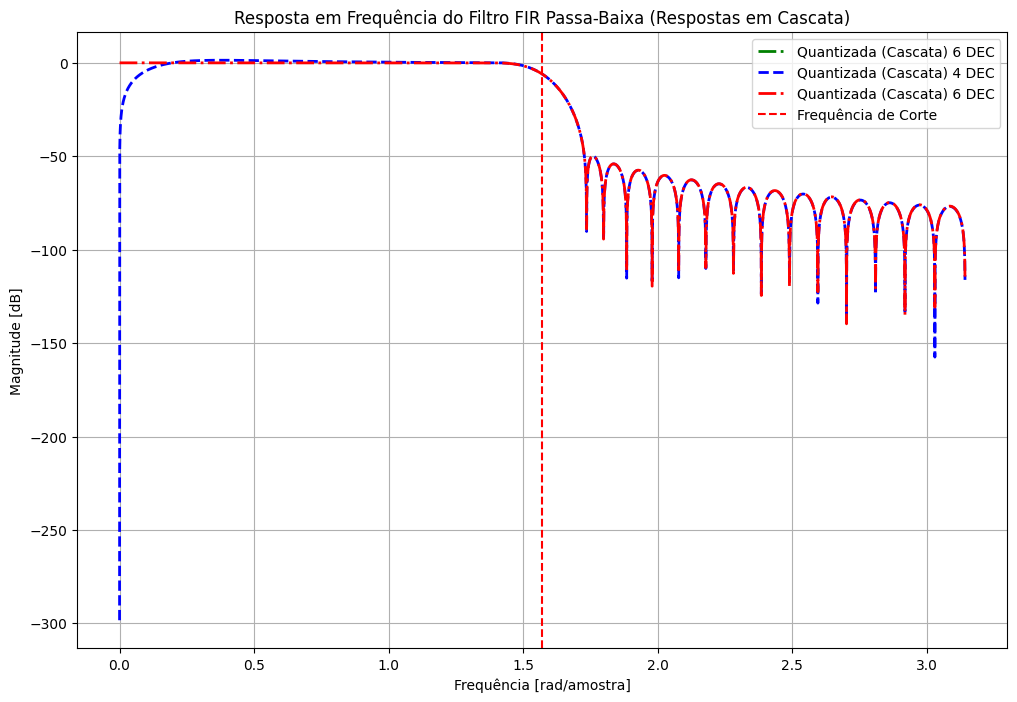

In [73]:

# Plot das respostas em frequência (Respostas em Cascata)
plt.figure(figsize=(12, 8))
plt.plot(
    frequencias_q_sos_2dec, 20 * np.log10(np.abs(resposta_cascata_quantizada_2dec)),
    label='Quantizada (Cascata) 6 DEC', color='green', linestyle='-.', linewidth=2
)
plt.plot(
    frequencias_q_sos_4dec, 20 * np.log10(np.abs(resposta_cascata_quantizada_4dec)),
    label='Quantizada (Cascata) 4 DEC', color='blue', linestyle='--', linewidth=2
)
plt.plot(
    frequencias_q_sos_6dec, 20 * np.log10(np.abs(resposta_cascata_quantizada_6dec)),
    label='Quantizada (Cascata) 6 DEC', color='red', linestyle='-.', linewidth=2
)


plt.title('Resposta em Frequência do Filtro FIR Passa-Baixa (Respostas em Cascata)')
plt.xlabel('Frequência [rad/amostra]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.axvline(frequencia_corte, color='red', linestyle='--', label='Frequência de Corte')
plt.legend()
plt.show()

Com base nos gráficos analisados, podemos concluir que a forma direta de implementação de filtros FIR é significativamente mais sensível à quantização dos coeficientes, ou seja, à redução do número de casas decimais. Isso se deve ao fato de que pequenas alterações nos coeficientes afetam diretamente a resposta em frequência do filtro, resultando em mudanças perceptíveis na magnitude. Por outro lado, a forma em cascata demonstrou maior robustez à quantização, mantendo uma resposta em frequência mais estável mesmo com a redução do número de casas decimais. Essa diferença ocorre porque a estrutura em cascata divide o filtro em seções de segunda ordem, limitando a propagação de erros e tornando-a mais adequada para implementações em sistemas com precisão finita. Portanto, a forma em cascata é preferível em aplicações práticas onde a quantização dos coeficientes é inevitável.



### Transformações em frequência


A transformação em frequência de um filtro é uma técnica para modificar a resposta em frequência, permitindo que ele seja convertido de umk tipo para outro, como de para passa-alta, passa-faixa ou rejeita-faixa.

C:\Users\joser\AppData\Local\Temp\ipykernel_7212\4264960212.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_transf / np.pi, 20 * np.log10(magnitude_resposta), label=nome, linewidth=2)  # Em dB


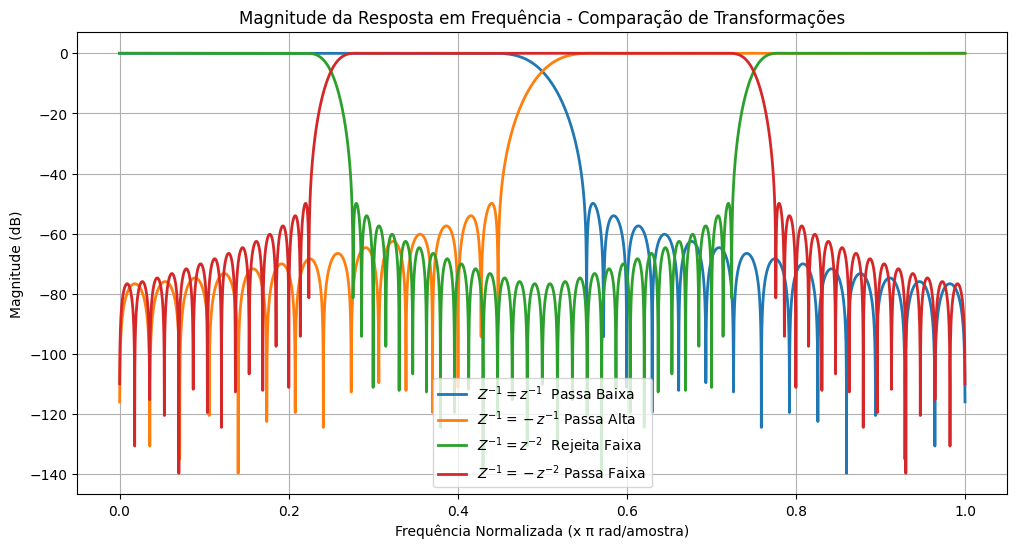

In [ ]:
# Função para aplicar transformações em frequência
def transformar_filtro(h_fir , transformacao):
    if transformacao == 1:
        # Z^{-1} = -z^{-1}
        return h_fir  * (-1) ** np.arange(len(h_fir ))
    #Inverte todos coeficientes
    elif transformacao == 2:
        # Z^{-1} = z^{-2}
        novos_h_fir = np.zeros(2 * len(h_fir ) - 1)
        novos_h_fir[::2] = h_fir 
        return novos_h_fir
    #Insere zeros entre os coeficientes do filtro
    elif transformacao == 3:
        # Z^{-1} = -z^{-2}
        novos_h_fir = np.zeros(2 * len(h_fir ) - 1)
        novos_h_fir[::2] = h_fir  * (-1) ** np.arange(len(h_fir ))
        return novos_h_fir
    # Insere zeros e inverte

# Aplicar as transformações no filtro
transformacoes = [
    (r'$Z^{-1} = z^{-1}$  Passa Baixa', h_fir),
    (r'$Z^{-1} = -z^{-1}$ Passa Alta', transformar_filtro(h_fir, 1)),
    (r'$Z^{-1} = z^{-2}$  Rejeita Faixa', transformar_filtro(h_fir, 2)),
    (r'$Z^{-1} = -z^{-2}$ Passa Faixa', transformar_filtro(h_fir, 3))
]

# Criar o gráfico com todas as magnitudes
plt.figure(figsize=(12, 6))

for nome, h_transf in transformacoes:
    w_transf, resposta_transformada = signal.freqz(h_transf, worN=8000)
    magnitude_resposta = np.abs(resposta_transformada)  # Obter a magnitude
    plt.plot(w_transf / np.pi, 20 * np.log10(magnitude_resposta), label=nome, linewidth=2)  # Em dB

# Configuração do gráfico
plt.title('Magnitude da Resposta em Frequência - Comparação de Transformações')
plt.xlabel('Frequência Normalizada (x π rad/amostra)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.legend()
plt.show()

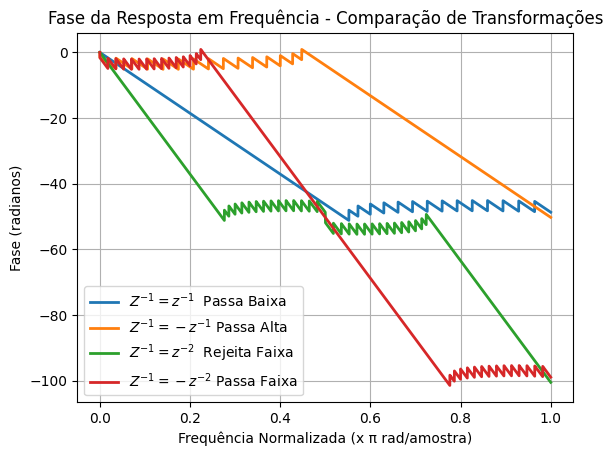

In [77]:
# Plotando a fase das transformações em frequência
for nome, h_transf in transformacoes:
    w_transf, resposta_transformada = signal.freqz(h_transf, worN=8000)
    fase_resposta = np.unwrap(np.angle(resposta_transformada))  # Corrigir descontinuidades
    plt.plot(w_transf / np.pi, fase_resposta, label=nome, linewidth=2)

# Configuração do gráfico
plt.title('Fase da Resposta em Frequência - Comparação de Transformações')
plt.xlabel('Frequência Normalizada (x π rad/amostra)')
plt.ylabel('Fase (radianos)')
plt.grid(True)
plt.legend()
plt.show()

Conclui-se, portanto, que as transformações em frequência acarretam em uma alteração da fase pois mudam o comportamento do atraso do filtro. Dobrar a resposta em frequencia faz a fase decair mais rapido, enquanto que a modulação -1^n causa inversão de fase (π de deslocamento).